In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, utils, datasets

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd
import sklearn

/opt/conda/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
!nvidia-smi

Thu Jun 13 09:19:47 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.66       Driver Version: 410.66       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:43:00.0 Off |                  N/A |
| 60%   66C    P2    90W / 260W |   1057MiB / 10988MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## load image

In [4]:
import os
transform = transforms.Compose([transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

data_image = {x:datasets.ImageFolder(root = os.path.join('./data/image',x),
                                     transform = transform)
              for x in ["train", "test", 'eval']}
batch_size = 16
data_loader_image = {x:torch.utils.data.DataLoader(dataset=data_image[x],
                                                batch_size = batch_size,
                                                shuffle = True)
                     for x in ["train", "test", 'eval']}

In [5]:
data_loader_image

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fe0388c9518>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fe0388c9710>,
 'eval': <torch.utils.data.dataloader.DataLoader at 0x7fe0388c9780>}

[tensor(7), tensor(2), tensor(5), tensor(1), tensor(4), tensor(3), tensor(7), tensor(7), tensor(3), tensor(7), tensor(4), tensor(1), tensor(5), tensor(6), tensor(3), tensor(1)]


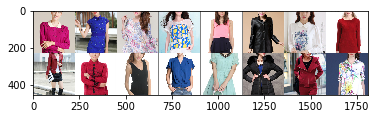

In [6]:
X_train, y_train = next(iter(data_loader_image["train"]))
mean = [0.5,0.5,0.5]
std  = [0.5,0.5,0.5]
img = torchvision.utils.make_grid(X_train)
img = img.numpy().transpose((1,2,0))
img = img*std+mean

print([i for i in y_train])
plt.imshow(img)


[tensor(4), tensor(5), tensor(0), tensor(1), tensor(0), tensor(4), tensor(3), tensor(7), tensor(7), tensor(0), tensor(6), tensor(7), tensor(3), tensor(3), tensor(0), tensor(4)]


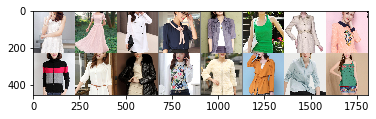

In [7]:
X_train, y_train = next(iter(data_loader_image["eval"]))
mean = [0.5,0.5,0.5]
std  = [0.5,0.5,0.5]
img = torchvision.utils.make_grid(X_train)
img = img.numpy().transpose((1,2,0))
img = img*std+mean

print([i for i in y_train])
plt.imshow(img)

In [8]:
net = torchvision.models.resnet152(pretrained=True)
net.fc = torch.nn.Linear(2048, 8)
net = net.to(device)

In [25]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0002)
epoch = 10

In [10]:
def train():
    net.train()
    total_loss = 0
    for image, label in tqdm(data_loader_image['train'], leave=False):
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()

        target = net(image)
        loss = criterion(target, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss/float(len(data_loader_image['train']))


In [26]:
for i in tqdm(range(epoch)):
    print(train())
    print(evaluate())

0.45217220030992605


(0.6296038918456055, tensor(3230, device='cuda:0'), tensor(77, device='cuda:0'))


0.43922875059631233


(0.6221346513414935, tensor(3237, device='cuda:0'), tensor(78, device='cuda:0'))


In [17]:
def evaluate():
    net.eval()
    corrects = eval_loss = 0

    for image, label in tqdm(data_loader_image['eval'], leave=False):
        image = image.to(device)
        label = label.to(device) 
        pred = net(image)
        loss = criterion(pred, label)

        eval_loss += loss.item()
        corrects += (torch.max(pred, 1)[1].view(label.size()).data == label.data).sum()
    return eval_loss/float(len(data_loader_image['eval'])), corrects, corrects*100/batch_size/len(data_loader_image['eval'])

In [16]:
evaluate()

(0.8125007806137262,
 tensor(2971, device='cuda:0'),
 tensor(71, device='cuda:0'))

In [27]:
torch.save(net, 'cv_model.pkl')